# Generalized Linear Models (GLM), a case study with the NHANES data

This notebook demonstrates a framework for regression analysis called
"generalized linear modeling", or GLM.  The focus here will be on fitting
these models to data using Python statistical modeling
libraries in the Jupyter notebook environment.  This notebook is primarily
a case study
using the [NHANES](https://www.cdc.gov/nchs/nhanes/index.htm) data.

Note that the NHANES data were collected as a designed survey, and in
general should be analyzed as such.  This means that survey design
information such as weights, strata, and clusters should be accounted
for in any analysis using NHANES.  But to introduce how generalized
linear models are used with independent data or with convenience
samples, we will not incorporate the survey structure of the NHANES sample
into the analyses conducted here.

As with our previous work, we will be using
the [Statsmodels](http://www.statsmodels.org) library for statistical
modeling, the [Pandas](http://pandas.pydata.org) library for data management,
the [Seaborn](https://seaborn.pydata.org) library for graphing,
and the
[Numpy](http://www.numpy.org) library for numerical calculations.

We begin by importing the libraries that we will be using.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import numpy as np

Next we will load the data.  The NHANES study encompasses multiple
waves of data collection.  Here we will only use the
2015-2016 data.  As with most data sets, there are some missing values
in the NHANES files.  While many of the methods demonstrated below would handle
missing values automatically (at least in a crude way), here we drop
up-front all rows with missing values in any of the key variables that
we will use in this notebook.

In [2]:
url = "https://raw.githubusercontent.com/kshedden/statswpy/master/NHANES/merged/nhanes_2015_2016.csv"
da = pd.read_csv(url)

# Drop unused columns, drop rows with any missing values.
vars = ["BPXSY1", "RIDAGEYR", "RIAGENDR", "RIDRETH1", "DMDEDUC2", "BMXBMI", "SMQ020"]
da = da[vars].dropna()

## Mean/variance relationships

In linear regression, we fit models for the population mean structure that have the form

$$
E[y | x_1, \ldots, x_p] = b_0 + b_1x_1 + \cdots + b_px_p,
$$

where $b_0 + b_1x_1 + \cdots + x_px_p$ is called the *linear predictor*.

Linear regression works best when the population variance structure is homosedastic:

$$
{\rm Var}[y | x_1, \ldots, x_p] = \sigma^2.
$$

Linear regression models are most commonly fit using the fitting procedure called
*least squares*.  When using least
squares to fit a linear regression model, the estimates of the mean structure parameters
$b_0, \ldots, b_p$ achieve their greatest accuracy when the population variance is approximately
homoscedastic.  But with a loss of efficiency (that in many settings is not large),
the mean structure parameters remain accurately estimated by least squares
even when the variance structure is not homoscedastic.

Generalized linear models (GLMs) are a collection of approaches for regression analysis
that extend the basic linear model in two ways:

* The mean structure can be related to the linear prediction via a *link function*,
e.g. the $\log$ link function:

$$
\log E[y | x_1, \ldots, x_p] = b_0 + b_1x_1 + \cdots b_px_p.
$$

In general, the link function $g$ satisfies

$$
g(E[y | x_1, \ldots, x_p]) = b_0 + b_1x_1 + \cdots b_px_p.
$$

* The conditional variance can be a function of the conditional mean, e.g.

$$
{\rm Var} [y | x_1, \ldots, x_p] = E[y | x_1, \ldots, x_p].
$$

In general, the conditional variance can be expressed as

$$
{\rm Var} [y | x_1, \ldots, x_p] = \phi f(E[y | x_1, \ldots, x_p]),
$$

of, by writing $\mu = E[y | x_1, \ldots, x_p]$, we have ${\rm Var} = \mu\cdot(1-\mu)$.

Thus, GLM's explicitly incorporate heteroscedasticicity (non-constant variance)
through this "mean/variance relationship".  The parameter $\phi$ is called
the *scale parameter* and will be discussed further below.

Note that we can use the identity link function $g(x) = x$ and the constant
mean/variance relationship $f(x) = 1$, which gives us back the linear model.
Thus, the linear model is one type of GLM.

Note that linear regression is often used after applying a transformation to the
dependent variable.  For example, if we log transform the dependent variable
and then fit a linear regression model, we are estimating the mean structure

$$
E[\log(y) | x_1, \ldots, x_p] = b_0 + b_1x_1 + \cdots + b_px_p.
$$

This is closely related to fitting a GLM with a log link function, but
is not exactly equivalent to it, since $E[\log(y)]$ is not equal to
$\log(E[y])$.  Either of these approaches may provide a good model,
but the two models that are being fit are not the same.

## Limited dependent variables

Another perspective on GLMs is that they are useful when the dependent
variable is restricted to lie in a subset of values.  The most common
such subsets are the non-negative integers, the positive real line, and the
unit interval.  Specific GLMs that we will discuss below are defined
in terms of probability distributions that obey these constraints.

## Logistic regression

Logistic regression is by far the most commonly used GLM.
It is used when the outcome variable is *binary*,
meaning that it can take on only two distinct values.
The behavior of a binary random value is entirely determined
by its "success probability", where "success" is a generic
term for one of the two possible outcomes.  For example, in
a clinical trial, substantial improvement might be deemed
a success, with less than substantial improvement being
viewed as a failure.  The success probability in this setting
would be the probability
that a substantial improvement in symptoms occurs.
Sometimes this is called
instead the "event probability".

The distribution of a binary random variable is entirely determined
by the success probability $p$.  In a regression analysis,
we have many observations $y_i$ of the dependent variable, and each
is accompanied with a covariate vector $x_i$.  This covariate vector
may determine the success probability, so we write $p(x)$ for the
success probability of an observation with covariate vector $x$.
Thus, for each $i$, $y_i$ is a binary random variable with
success probability $p(x_i)$.

As discussed above, in a GLM the link function maps the expected
value of the outcome to the linear predictor.  In logistic regression, the link
function is the *logit function*, or the *log odds function*
$\log(p/(1-p)$.  Note that while $p$ is restricted to lie in $[0, 1]$
the odds $p/(1-p)$ can be any positive real number, and the log
odds can be any real number.

Thus, in logistic regression, we have

$$
\log \frac{E[y|x_1, \ldots, x_p]}{1 - E[y|x_1, \ldots, x_p]} = b_0 + b_1x_1 + \cdots + b_px_p.
$$

The variance function for logistic regression
is determined by the fact that for a binary random variable
with success probability $p$, the variance is $p\cdot(1-p)$.  Thus,
the mean variance relationship is given by the ${\rm Var}(\mu) = \mu(1-\mu)$.
Unlike other GLM's that we will see later, the variance is uniquely determined
by the mean, so the scale parameter $\phi$ is fixed at 1.

As an initial
illustration, we will work with the NHANES variable
[SMQ020](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/SMQ_I.htm#SMQ020),
which asks whether a person has smoked at least 100 cigarettes in
their lifetime (if this is the case, we say that the person has a
"smoking history").  Below we create a version of this variable in
which smoking and non-smoking are coded as 1 and 0, respectively, and
rare responses like *don't know* and *refused to answer* are coded as
missing values.

In [3]:
da["smq"] = da.SMQ020.replace({2: 0, 7: np.nan, 9: np.nan})

### Odds and log odds

Logistic regression provides a model for the *odds* of an event
happening.  Recall that if an event has probability `p`, then the odds
for this event is `p/(1-p)`.  The odds is a mathematical
transformation of the probability onto a different scale.  For
example, if the probability is 1/2, then the odds is 1.

To begin, we look at the odds of alcohol use for women and men separately.

In [4]:
# Create a labeled version of the gender variable
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})

c = pd.crosstab(da.RIAGENDRx, da.smq).apply(lambda x: x/x.sum(), axis=1)
c["odds"] = c.loc[:, 1] / c.loc[:, 0]
c

smq,0.0,1.0,odds
RIAGENDRx,,,
Female,0.680197,0.319803,0.470162
Male,0.467453,0.532547,1.139252


We see that the probability that a woman has ever smoked is
substantially lower than the probability that a man has ever smoked
(30% versus 51%).  This is reflected in the odds for a woman smoking
being much less than 1 (around 0.47), while the odds for a man smoking
is around 1.14.

It is common to work with *odds ratios* when comparing two groups.
This is simply the odds for one group divided by the odds for the
other group.  The odds ratio for smoking, comparing males to females,
is around 2.4.  In other words, a man has around 2.4 times greater
odds of smoking than a woman (in the population represented by these
data).

In [5]:
c.odds.Male / c.odds.Female

2.423105552613186

It is conventional to work with odds on the logarithmic scale.  To
understand the motivation for doing this, first note that the neutral
point for a probability is 0.5, which is equivalent to an odds of 1
and a log odds of 0.  Populations where men smoke more than women will
have odds between 1 and infinity, with the exact value depending on
the magnitude of the relationship between the male and female smoking
rates.  Populations where women smoke more than men would have odds
falling between 0 and 1.

We see that the scale of the odds statistic is not symmetric.  It is
usually arbitrary in which order we compare two groups -- we could
compare men to women, or compare women to men.  An odds of 2 (men have
twice the odds of smoking as women) is equivalent in strength to an
odds of 1/2 (women have twice the odds of smoking as men).  Taking the
log of the odds centers the scale at zero, and symmetrizes the
interpretation of the scale.

To interpret the log odds when comparing the odds for two groups,
it is important to remember the following facts:

* A probability of 1/2, an odds of 1, and a log odds
of 0 are all equivalent.

* A positive log odds indicates that the first
group being compared has greater odds (and greater probability) than
the second group.

* A negative log odds indicates that the second
group being compared has greater odds (and greater probability) than
the first group.

* The scale of the log odds statistic is symmetric in
the sense that a log odds of, say, 2, is equivalent in strength to a
log odds of -2 (but with the groups swapped in terms of which has the
greater probability).

If you know that the log odds when comparing two groups is a given
value, say 2, and you want to report the odds, you simply exponentiate
the log odds to get the odds, e.g. `exp(2)` is around 7.4. Note
however that you cannot recover the individual probabilities (or their
ratio) from an odds ratio.`

Below we show the log odds for smoking history status of females and
males in the NHANES data.  The fact that the log odds for females is
negative reflects that fact that substantially less than 50% of
females have a history of smoking.  The log odds for males is closer to
0, consistent with around half of males having a history of smoking.

In [6]:
# Add a column containing the log odds
c["logodds"] = np.log(c.odds)
c

smq,0.0,1.0,odds,logodds
RIAGENDRx,,,,
Female,0.680197,0.319803,0.470162,-0.754679
Male,0.467453,0.532547,1.139252,0.130371


### A basic logistic regression model

Now that we have a clear understanding of log odds statistics, we will
fit a logistic regression.  The dependent variable (outcome) of this
initial model is smoking status, and the only covariate is gender.
Thus, we are looking at gender as a predictor of smoking status.  We
fit the model using the `GLM` function, which fits a
Generalized Linear Model.  Logistic regression is one type of GLM.
The `family` parameter specifies which particular GLM we are fitting.
Here we use the `Binomial` family to perform a logistic regression.

In [7]:
model = sm.GLM.from_formula("smq ~ RIAGENDRx", family=sm.families.Binomial(), data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    smq   No. Observations:                 5094
Model:                            GLM   Df Residuals:                     5092
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3350.6
Date:                Tue, 29 Jan 2019   Deviance:                       6701.2
Time:                        13:46:20   Pearson chi2:                 5.09e+03
No. Iterations:                     4   Covariance Type:             nonrobust
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.7547      0.042    -18.071      0.000      -0.837      -0.673
RIAGENDRx[T.Male]     0.8851      0.058     15.227      0.000       0.771       0.999
=====================================================================================
"""

To see the connection between logistic regression and the log odds
statistic, note that the logistic regression coefficient for male
gender is exactly equal to the difference between the log odds
statistics for males and females:

In [8]:
c.logodds.Male - c.logodds.Female

0.8850500036644218

This relationship will always hold when conducting a logistic
regression with a single binary covariate.

In general, a logistic regression model will have multiple covariates
that may not be binary, but there is still an important connection
between logistic regression and odds ratios.  In this more general
setting, we will use a more general type of odds ratio, which we will
explore further next.

### Adding additional covariates

As with linear regression, we can include multiple covariates in a
logistic regression.  Below we fit a logistic regression for smoking
status using age (RIDAGEYR) and gender as covariates.

In [9]:
model = sm.GLM.from_formula("smq ~ RIDAGEYR + RIAGENDRx", family=sm.families.Binomial(), data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    smq   No. Observations:                 5094
Model:                            GLM   Df Residuals:                     5091
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3296.6
Date:                Tue, 29 Jan 2019   Deviance:                       6593.2
Time:                        13:46:20   Pearson chi2:                 5.10e+03
No. Iterations:                     4   Covariance Type:             nonrobust
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.6166      0.095    -16.985      0.000      -1.803      -1.430
RIAGENDRx[T.Male]     0.8920      0.059     15.170      0.000       0.777       1.007
RIDAGEYR              0.0172      0.002     10.289      0.000       0.014       0.021
=====================================================================================
"""

Adding age to the model leads to a very small shift in the gender
parameter (it changed from 0.885 to 0.892).  In general, regression
coefficients can change a lot when adding or removing other variables
from a model.  But in this case the change is quite minimal.  This
fitted model suggests that older people are more likely to have a
history of smoking than younger people.  The log odds for smoking
increases by 0.017 for each year of age.  This effect is additive, so
that comparing two people whose ages differ by 20 years, the log odds
of the older person smoking will be around 0.34 units greater than the
log odds for the younger person smoking, adn the odds for the older
person smoking will be around `exp(0.34) = 1.4` times greater than
the odds for the younger person smoking.

The greater prevalence of smoking history among older people could be
partly due to the definition of smoking status that we are using here -- an older person has
had more time to smoke 99 cigarettes than a younger person.  However
most people who smoke begin when they are young, and the smoking rate
in the US has been slowly declining for several decades.  Thus, it is
likely that the increased smoking levels in older people are driven
primarily by real shifts in behavior.

As with linear regressin, the roles of age and gender in the logistic
regression model can be seen as being additive, but here the additivity
is on the scale of log odds, not odds or probabilities.  If we compare
a 30 year old female to a 50 year old male, the log odds for the male
being a smoker are `0.89 + 0.34 = 1.23` units greater than the log odds
for the female being a smoker.  The value of 0.89 in this expression is
the change attributable to gender, and the value of 0.34 is the change
attributable to age.  Again, we can exponentiate to convert these
effects from the log odds scale to the odds scale.  Since
`exp(0.89 + 0.34) = exp(0.89)*exp(0.34) = 2.44*1.41` we can state
that male gender is associated with a 2.44 fold increase in the odds
of smoking, and 20 years of age is associated with a 2.44 fold increase
in the odds for smoking.  These two effects are multiplied when
discussing the odds, so a 50 year old man has `exp(1.23) = 3.42` fold
greater odds of smoking than a 30 year old woman.

In this logistic regression model with two covariates, the
coefficients for age and gender both have interpretations in terms of
*conditional log odds*.  This generalizes the interpretation of a
logistic regression coefficient in terms of marginal log odds that we
discussed above.  When there are two or more covariates in a logistic
regression model, we always need to think in terms of conditional, not
marginal log odds.

Specifically, the coefficient of around 0.89 for male gender impacts the conditional
log odds in the sense that when comparing a male to a female at a
fixed age, the male will have 0.89 units greater log odds for smoking than
the female.  This relationship holds within any age (i.e. it holds
among all people of age 30, and among all people of age 70).  In this
sense, it is a *conditional* coefficient because it is only
interpretable when holding the other variables in the model fixed.
Similarly, the coefficient of around 0.02 for age holds within a
gender.  Comparing two females whose ages differ by one year, the
older female has 0.02 units greater log odds for smoking than the
younger female.  This same contrast holds for males.

### A logistic regression model with three predictors

Next we fit a logistic regression model, again for smoking, including
educational attainment as a predictor.  The educational attainment in
NHANES is called
[DMDEDUC2](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#DMDEDUC2),
and we will recode it so that the meaning of the levels becomes more
clear.  We will call the recoded variable `DMDEDUC2x`.

In [10]:
da["DMDEDUC2x"] = da.DMDEDUC2.replace({1: "lt9", 2: "x9_11", 3: "HS", 4: "SomeCollege",
                                       5: "College", 7: np.nan, 9: np.nan})
model = sm.GLM.from_formula("smq ~ RIDAGEYR + RIAGENDRx + DMDEDUC2x", family=sm.families.Binomial(), data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    smq   No. Observations:                 5093
Model:                            GLM   Df Residuals:                     5086
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3201.2
Date:                Tue, 29 Jan 2019   Deviance:                       6402.4
Time:                        13:46:20   Pearson chi2:                 5.10e+03
No. Iterations:                     4   Covariance Type:             nonrobust
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.3060      0.114    -20.174      0.000      -2.530      -2.082
RIAGENDRx[T.Male]            0.9096      0.060     15.118      0.000       0.792       1.028
DMDEDUC2x[T.HS]              0.9434      0.090     10.521      0.000       0.768       1.119
DMDEDUC2x[T.SomeCollege]     0.8322      0.084      9.865      0.000       0.667       0.998
DMDEDUC2x[T.lt9]             0.2662      0.109      2.438      0.015       0.052       0.480
DMDEDUC2x[T.x9_11]           1.0986      0.107     10.296      0.000       0.889       1.308
RIDAGEYR                     0.0183      0.002     10.582      0.000       0.015       0.022
============================================================================================
"""

We see that the "Female" level of the gender variable, and the
"College" level of the educational attainment variable are the
reference levels, as they are not shown in the output above.  We have
discussed the gender and age variables above, but the educational
attainment variable is new for us.  All non-reference coefficients for
the educational attainment are positive, while the `College`
coefficient, as the reference coefficient, is exactly zero.  Thus, we
see that people with a college degree have the lowest rate of smoking,
followed by people with less than 9 years of schooling, then
(after a large gap) people
with some college, then people with a high school degree (and no
college), and finally (with the greatest rate of smoking), people with
9-11 years of schooling.  The overall story here is that smoking rates
are much lower for people who graduated from college or did not start
high school, presumably for very different reasons.  On the other
hand, people with some high school, people who completed high school,
and people who began but did not complete college have much higher
rates of smoking.  The odds ratio between the former and the latter
group depends on the specific subgroups being compared, but can be
almost `3 = exp(1.09)`.

As noted above when we were discussing linear regression, it is
important to remember that a coefficient in a logistic regression are
"conditional" on the other variables being held fixed.  For example,
the log odds ratio of 1.09 between people with 9-11 years of schooling
and people who completed college applies only when comparing people with
the same age and gender.

### Visualization of the fitted models

Visualization of fitted logistic regression models is more challenging
than visualization of fitted linear models, but is still worth
pursuing.  We can begin by plotting the fitted proportion of the
population that smokes, for various subpopulations defined by the
regression model.  We will focus here on how the smoking rate varies
with age, so we restrict the population to female college graduates.

The following plot shows the fitted log odds (or logit) probability
for the smoking outcome as a function of age.  The grey band is a
simultaneous 95% simultaneous confidence band, as discussed above in
the case of a linear model.

Text(0,0.5,'Smoking')

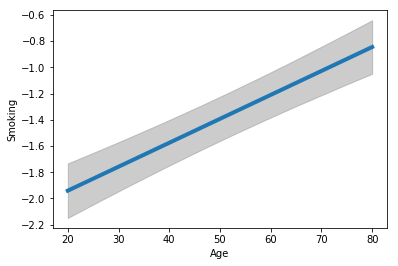

In [11]:
from statsmodels.sandbox.predict_functional import predict_functional

values = {"RIAGENDRx": "Female", "RIAGENDR": 1, "BMXBMI": 25,
          "DMDEDUC2": 1, "RIDRETH1": 1, "SMQ020": 1,
          "DMDEDUC2x": "College", "BPXSY1": 120}

pr, cb, fv = predict_functional(result, "RIDAGEYR",
                values=values, ci_method="simultaneous")

ax = sns.lineplot(fv, pr, lw=4)
ax.fill_between(fv, cb[:, 0], cb[:, 1], color='grey', alpha=0.4)
ax.set_xlabel("Age")
ax.set_ylabel("Smoking")

We can display the same plot in terms of probabilities instead of in
terms of log odds.  The probability can be obtained from the log odds
using the relationship `p = 1 / (1 + exp(-o))` where `o` is the log
odds.  Note that while the age and log odds are linearly related, age
has a curved relationship with probability.  This is necessary since
probabilities must remain between 0 and 1, a linear relationship would
eventually exit the domain.

Text(0,0.5,'Smoking')

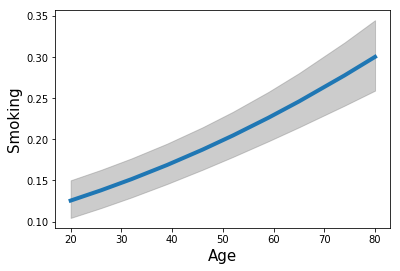

In [12]:
pr1 = 1 / (1 + np.exp(-pr))
cb1 = 1 / (1 + np.exp(-cb))
ax = sns.lineplot(fv, pr1, lw=4)
ax.fill_between(fv, cb1[:, 0], cb1[:, 1], color='grey', alpha=0.4)
ax.set_xlabel("Age", size=15)
ax.set_ylabel("Smoking", size=15)

Next we turn to diagnostic plots that are intended to reveal certain
aspects of the data that may not be correctly captured by the model.
The three plots below are intended to reveal any curvature in the mean
relationship between the outcome and one of the covariates. We used
the partial regression plotting technique above for this same purpose
when working with linear models.

In the case of logistic regression, the three techniques
demonstrated below can identify
major discrepancies between the fitted model and the population, but
evidence for small discrepancies is not reliable unless the sample
size is very large.  The CERES technique has the strongest theoretical
support.  Taken at face value, the plots below suggest that smoking
rates may rise slightly faster for people between the ages of 20 and 35,
and again for people between the ages of 50 and 60, with a period of minimal
increase between these age intervals.  This would contradict the
perfectly linear model for age (on the log odds scale)
that we have specified in our model.
These plotting techniques can be useful at identifying
possible opportunities for future analysis with additional data, but
do not identify features that can be claimed with high confidence
using the present data.

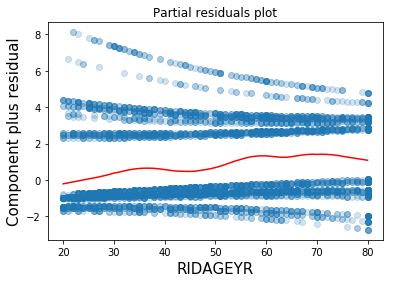

In [13]:
fig = result.plot_partial_residuals("RIDAGEYR")
ax = fig.get_axes()[0]
ax.lines[0].set_alpha(0.2)

from statsmodels.graphics.regressionplots import add_lowess
_ = add_lowess(ax)

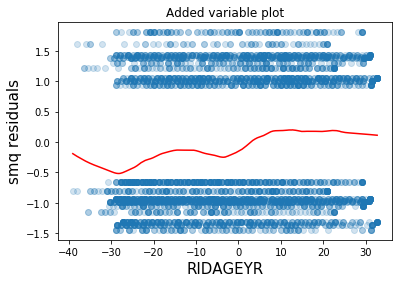

In [14]:
fig = result.plot_added_variable("RIDAGEYR")
ax = fig.get_axes()[0]
ax.lines[0].set_alpha(0.2)
_ = add_lowess(ax)

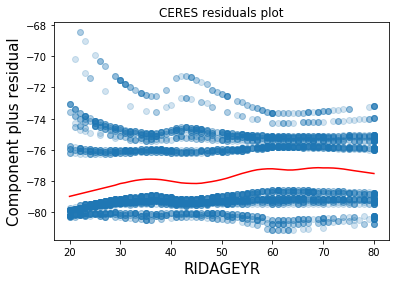

In [15]:
fig = result.plot_ceres_residuals("RIDAGEYR")
ax = fig.get_axes()[0]
ax.lines[0].set_alpha(0.2)
_ = add_lowess(ax)

## Poisson regression

Poisson regression is a type of GLM based on the Poisson distribution.  A Poisson random
variable is supported on the non-negative integers.  The distribution is fully
determined by its mean $\mu$.  The Poisson distribution can be used to describe many
phenomena, but is particularly useful when we are observing the number of times that
some event happened, when there were a large number of opportunities for the event to
happen, each with a small probability.  For example, suppose we have a large sample of drivers
and divide them into disjoint groups of 10,000 drivers at random.  If we were then to
count the total number of
traffic accidents per group, these counts may follow a Poisson distribution.

In a regression setting, we want the distribution of the dependent variable $y$ to
be related to the covariate vector $x$.  Thus, for Poisson regression we want the
mean of $y$ to be expressed as $\mu(x)$.  In Poisson regression, this is usually
accomplished using the log link function, so that

$$
\log(\mu) = \log E[y|x_1, \ldots, x_p] = b_0 + b_1x_1 + \cdots + b_px_p.
$$

The Poisson distribution has the property that the variance is equal to the mean.  Thus
the mean/variance relationship in a Poisson regression is described by ${\rm Var}(\mu) = \mu$.
In practice, data often do not follow a Poisson distribution, because the variance
violates this relationship.  We will see this below and discuss some
additional GLM approaches that are closely related to the Poisson GLM, but that specify the
mean/variance relationship in a different way.

To illustrate the Poisson GLM, we will use the household size variable `DMDHHSIZ` from NHANES.
First we create a dataset that includes this variable, along with some other variables that
may be related to it.

In [16]:
url = "https://raw.githubusercontent.com/kshedden/statswpy/master/NHANES/merged/nhanes_2015_2016.csv"
da = pd.read_csv(url)

da = da[["DMDEDUC2", "DMDHHSIZ", "DMDCITZN", "RIDRETH1", "RIAGENDR", "INDFMPIR", "DMDMARTL", "RIDAGEYR"]]

da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})

# Check to see what we lose by dropping rows with missing values
print(pd.isnull(da).sum(0))
print(da.shape)
print(da.dropna().shape)
da = da.dropna()

DMDEDUC2     261
DMDHHSIZ       0
DMDCITZN       1
RIDRETH1       0
RIAGENDR       0
INDFMPIR     601
DMDMARTL     261
RIDAGEYR       0
RIAGENDRx      0
dtype: int64
(5735, 9)
(4908, 9)


Next we fit a model predicting the size of a person's household from the person's age and gender,
including an interaction between age and gender, and using splines to allow for curvature in the
role of age.

In [17]:
model = sm.GLM.from_formula("DMDHHSIZ ~ bs(RIDAGEYR, 3)*RIAGENDRx", family=sm.families.Poisson(), data=da)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               DMDHHSIZ   No. Observations:                 4908
Model:                            GLM   Df Residuals:                     4900
Model Family:                 Poisson   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9055.3
Date:                Tue, 29 Jan 2019   Deviance:                       3710.5
Time:                        13:46:23   Pearson chi2:                 3.85e+03
No. Iterations:                     4   Covariance Type:             nonrobust
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                1.2032      0.040     29.825      0.000       1.124       1.282
RIAGENDRx[T.Male]                        0.0120      0.059      0.204      0.838      -0.103       0.127
bs(RIDAGEYR, 3)[0]                       0.5898      0.118      4.996      0.000       0.358       0.821
bs(RIDAGEYR, 3)[1]                      -0.3711      0.079     -4.720      0.000      -0.525      -0.217
bs(RIDAGEYR, 3)[2]                      -0.4739      0.067     -7.105      0.000      -0.605      -0.343
bs(RIDAGEYR, 3)[0]:RIAGENDRx[T.Male]    -0.1551      0.171     -0.909      0.363      -0.490       0.179
bs(RIDAGEYR, 3)[1]:RIAGENDRx[T.Male]     0.1374      0.112      1.229      0.219      -0.082       0.356
bs(RIDAGEYR, 3)[2]:RIAGENDRx[T.Male]     0.0061      0.096      0.063      0.949      -0.181       0.193
========================================================================================================
"""

There is a strong association between age and household size, but there
isn't much evidence that gender plays a role here.  Nevertheless we will make
a plot of the fitted means by gender just to see how they look:

Text(0,0.5,'Log expected household size')

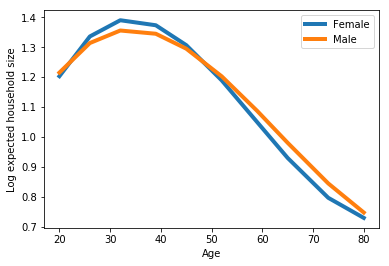

In [18]:
values = {"DMDHHSIZ": 0, "DMDCITZN": 0, "RIAGENDR": 0, "DMDEDUC2": 0, "INDFMPIR": 0,
          "RIDRETH1": 0, "DMDMARTL": 0}

for gender in "Female", "Male":
    values["RIAGENDRx"] = gender
    pr, cb, fv = predict_functional(result, "RIDAGEYR",
                    values=values, ci_method="simultaneous")
    ax = sns.lineplot(fv, pr, lw=4, label=gender)

ax.set_xlabel("Age")
ax.set_ylabel("Log expected household size")

Marital status likely also plays a role, and it turns out that
a role for gender also emerges now that we consider marital status:

In [19]:
# 1 if the person is married, 0 otherwise
da["Married"] = (da.DMDMARTL == 1).astype(np.int)

model = sm.GLM.from_formula("DMDHHSIZ ~ bs(RIDAGEYR, 3)*Married + bs(RIDAGEYR, 3)*RIAGENDRx + Married*RIAGENDRx", family=sm.families.Poisson(), data=da)
result = model.fit(scale="X2")
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               DMDHHSIZ   No. Observations:                 4908
Model:                            GLM   Df Residuals:                     4895
Model Family:                 Poisson   Df Model:                           12
Link Function:                    log   Scale:                         0.76353
Method:                          IRLS   Log-Likelihood:                -11697.
Date:                Tue, 29 Jan 2019   Deviance:                       3462.1
Time:                        13:46:24   Pearson chi2:                 3.74e+03
No. Iterations:                     7   Covariance Type:             nonrobust
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                1.2611      0.038     33.400      0.000       1.187       1.335
RIAGENDRx[T.Male]                        0.0236      0.051      0.465      0.642      -0.076       0.123
bs(RIDAGEYR, 3)[0]                       0.2899      0.120      2.413      0.016       0.054       0.525
bs(RIDAGEYR, 3)[1]                      -0.5220      0.086     -6.058      0.000      -0.691      -0.353
bs(RIDAGEYR, 3)[2]                      -0.6180      0.064     -9.585      0.000      -0.744      -0.492
bs(RIDAGEYR, 3)[0]:RIAGENDRx[T.Male]    -0.4087      0.153     -2.665      0.008      -0.709      -0.108
bs(RIDAGEYR, 3)[1]:RIAGENDRx[T.Male]     0.0656      0.101      0.649      0.517      -0.133       0.264
bs(RIDAGEYR, 3)[2]:RIAGENDRx[T.Male]    -0.2089      0.087     -2.391      0.017      -0.380      -0.038
Married                                 -0.1815      0.066     -2.770      0.006      -0.310      -0.053
Married:RIAGENDRx[T.Male]                0.1589      0.030      5.236      0.000       0.099       0.218
bs(RIDAGEYR, 3)[0]:Married               0.7488      0.172      4.358      0.000       0.412       1.086
bs(RIDAGEYR, 3)[1]:Married               0.1663      0.103      1.617      0.106      -0.035       0.368
bs(RIDAGEYR, 3)[2]:Married               0.4791      0.097      4.948      0.000       0.289       0.669
========================================================================================================
"""

The model fit above includes all two-way interactions among age, gender, and marital status.
The model with three-way interactions did not converge.  There are ways to work around
such convergence issues, but here we will focus on the simpler model without the
three-way interaction.

To understand this model, we can plot the mean curves for married and unmarried
women and for married and unmarried men:

Text(0,0.5,'Log expected household size')

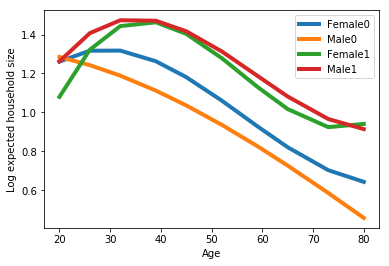

In [20]:
values["Married"] = 0

for married in 0, 1:
    for gender in "Female", "Male":
        values["Married"] = married
        values["RIAGENDRx"] = gender
        pr, cb, fv = predict_functional(result, "RIDAGEYR",
                        values=values, ci_method="simultaneous")
        ax = sns.lineplot(fv, pr, lw=4, label=gender + str(married))

ax.set_xlabel("Age")
ax.set_ylabel("Log expected household size")

There is a lot going on here, but here are some possible interpretations:

* For married people, household size increases up to around age around age 40.
Presumably this is due to children living at home and subsequently leaving
home.

* Household size for married women and married men of a fixed age are similar,
but unmarried women live in larger households than unmarried men, likely because
they are living with children or parents.

Just because a variable has integer values does not mean that it follows a Poisson
distribution.  As noted above, one key property of the Poisson distribution is
that its conditional variance and conditional mean are equal.  With enough data,
we can assess this graphically as shown below.  We can also incorporate a scale
parameter which allows the variance to be proportional to, but not necessarily
equal to the mean.

0.7635339248997839


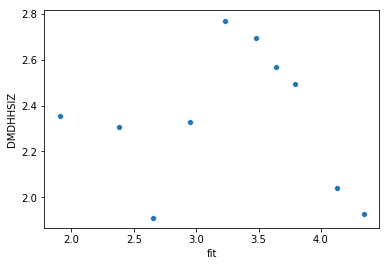

In [21]:
da["fit"] = result.fittedvalues
da["fitd"] = pd.qcut(da.fit, 10)
dx = da.groupby("fitd").agg({"fit": np.mean, "DMDHHSIZ": np.var})

sns.scatterplot(x="fit", y="DMDHHSIZ", data=dx)

print(result.scale)

The plot above shows little evidence of an increasing trend between the mean and
the variance.
This leads us to wonder whether the Poisson model was a good choice in the first
place.  We can compare the AIC (lower is better) to assess this.

In [22]:

# A linear model fit with least squares
model0 = sm.OLS.from_formula("DMDHHSIZ ~ bs(RIDAGEYR, 3)*Married + bs(RIDAGEYR, 3)*RIAGENDRx + Married*RIAGENDRx", data=da)
result0 = model0.fit()
print("OLS AIC:", result0.aic)

# Our Poisson model
print("Poisson AIC:", result.aic)

# Fit some negative binomial models
print("Negative binomial AICs:")
for shape in 0.1, 0.5, 1, 2:
    model1 = sm.GLM.from_formula("DMDHHSIZ ~ bs(RIDAGEYR, 3)*Married + bs(RIDAGEYR, 3)*RIAGENDRx + Married*RIAGENDRx", family=sm.families.NegativeBinomial(alpha=shape), data=da)
    result1 = model1.fit()
    print(result1.aic)

OLS AIC: 18101.122841508586
Poisson AIC: 23420.130436573178
Negative binomial AICs:
18406.539197253944


20504.08370326786
22557.149821402694


25517.52317278125


In [23]:
url = "https://raw.githubusercontent.com/kshedden/statswpy/master/NHANES/merged/nhanes_2015_2016.csv"
da = pd.read_csv(url)

dx = da.groupby(["SDMVSTRA", "SDMVPSU"]).agg({"BPXSY1": [np.size, lambda x: np.sum(x > 140)],
                                              "RIDAGEYR": np.mean, "INDFMPIR": np.mean,
                                              "RIAGENDR": np.mean,
                                              "DMDMARTL": lambda x: np.sum(x == 1)})
print(dx.columns)

dx.columns = [':'.join(c).strip() for c in dx.columns.values]
dx = dx.rename(columns={"RIDAGEYR:mean": "Age", "BPXSY1:size": "N",
                        "BPXSY1:<lambda>": "HighBP", "INDFMPIR:mean": "INDFMPIR",
                        "RIAGENDR:mean": "RIAGENDR", "DMDMARTL:<lambda>": "DMDMARTL"})
print(dx.head())

MultiIndex(levels=[['INDFMPIR', 'DMDMARTL', 'RIAGENDR', 'BPXSY1', 'RIDAGEYR'], ['<lambda>', 'mean', 'size']],
           labels=[[0, 1, 2, 3, 3, 4], [1, 0, 1, 2, 0, 1]])
                  INDFMPIR  DMDMARTL  RIAGENDR      N  HighBP        Age
SDMVSTRA SDMVPSU                                                        
119      1        2.324718      66.0  1.576471  170.0    18.0  47.747059
         2        2.446147      44.0  1.653543  127.0    23.0  53.464567
120      1        1.952376     121.0  1.497487  199.0    22.0  43.381910
         2        2.958462      83.0  1.496552  145.0    10.0  44.482759
121      1        1.996270      82.0  1.485149  202.0    31.0  45.608911

In [24]:
model = sm.GLM.from_formula("HighBP ~ Age + INDFMPIR + RIAGENDR + DMDMARTL", family=sm.families.Poisson(), data=dx)
result = model.fit(scale="X2")
print(result.summary())
print(result.scale)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 HighBP   No. Observations:                   30
Model:                            GLM   Df Residuals:                       25
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          2.2204
Method:                          IRLS   Log-Likelihood:                -47.349
Date:                Tue, 29 Jan 2019   Deviance:                       55.281
Time:                        13:46:25   Pearson chi2:                     55.5
No. Iterations:                     6   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0686      2.066      1.969      0.049       0.019       8.118
Age            0.0501      0.017      2.983      0.0